# Maternal Health Risk Analysis and Classification

# 1. Problem Identification

Pregnant women often face risks due to insufficient information and inadequate healthcare, leading to complications and even death. It's crucial to monitor every stage of pregnancy for the well-being of both the mother and the baby. Early and proper care can significantly reduce preventable deaths, especially in rural areas. This notebook aims to analyze various factors affecting maternal health and develop a machine learning model to predict health risks during pregnancy.

# 2. Importing

## 2.1 Importing Packages

In [1]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
seed = 20

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv


## 2.2 Importing Dataset

In [3]:
data = pd.read_csv(r'/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


# 3. Variable Description and Identification 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


## 3.1 Variable Description

We can see total 6 variables, and each variables has 1014 observations.<br/>
   1. **Age**: ages in years when a women goes into labour.
   2. **SystolicBP**: Upper value of Blood Pressure in mmHg.
   3. **DiastolicBP**: Lower value of Blood Pressure in mmHg,
   4. **BS**: Blood sugar/glucose levels in terms of a molar concentration, mmol/L.
   5. **BodyTemp**: Woman body temperature.
   5. **HeartRate**: A resting heart rate in beats per minute.
   6. **Risk Level**: Predicted Risk Level during pregnancy considering the previous attributes.

Here, we have Risk Level as target variable, and the rest of the variables are predictor variables. 

## 3.2 Variable Data Types

**Categorical Variable**: Risk Level.

**Numerical Variable**: Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate.

## 3.3 Checking Null/Missing Values

In [5]:
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

There are no null/missing values in this dataset.

## 3.4 Checking Duplicates

Duplication just means that you have repeated data in your dataset. This could be due to things like data entry errors or data collection methods. 

In [6]:
print(f"There are {data.duplicated().sum()} duplicates data")
data.loc[data.duplicated(keep=False)].sort_values(by=data.columns.to_list())

There are 562 duplicates data


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
670,10,100,50,6.0,99.0,70,mid risk
849,10,100,50,6.0,99.0,70,mid risk
552,12,90,60,7.5,102.0,60,low risk
940,12,90,60,7.5,102.0,60,low risk
543,12,90,60,7.5,102.0,66,low risk
...,...,...,...,...,...,...,...
553,60,120,85,15.0,98.0,60,mid risk
772,60,120,85,15.0,98.0,60,mid risk
818,60,120,85,15.0,98.0,60,mid risk
114,63,140,90,15.0,98.0,90,high risk


Having 562 instances of duplicated data is a considerable amount. Duplicated data not only consumes additional storage space and hampers computational efficiency but also distorts analytical outcomes and compromises dataset integrity. Moreover, the presence of duplicates can contribute to overfitting, negatively impacting the model's predictive accuracy. Therefore, it's imperative to investigate the distribution of this duplicated data before advancing to subsequent stages of analysis.

# 4. Univariate Analysis

Univariate analysis focuses on studying individual variables within a dataset independently to understand their distribution, including their range of values and central tendencies. Unlike bivariate and multivariate analyses, univariate analysis does not explore relationships between variables but rather provides a summary of each variable's characteristics on its own.

The approach to conducting univariate analysis varies depending on whether the variable is categorical or numerical. When dealing with numerical variables, we typically assess the shape of their distribution, which can be symmetric or skewed, using tools such as histograms and density plots. On the other hand, for categorical variables, we utilize bar plots to visualize their absolute and relative frequency distributions.

## 4.1 Categorical Variables

When dealing with categorical variables, we'll examine the frequency distribution of the data through a bar plot. Another method to illustrate the relationships among different classes or categories of a variable is by using a pie or circle chart. In a pie chart, each segment depicts the proportion of the total phenomenon attributed to each class or group.

### 4.1.1 Risk Level

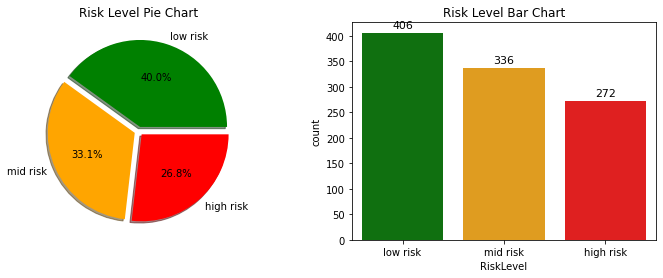

In [7]:
p_colors = ['green', 'orange', 'red']
risk_order = ["low risk", "mid risk", "high risk"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data["RiskLevel"].value_counts().plot(kind="pie", labels=risk_order, colors=p_colors, explode=[0.05, 0.05,  0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title("Risk Level Pie Chart")
ax[0].set_ylabel('')

count = sns.countplot(x="RiskLevel", data=data, ax=ax[1], order=risk_order, palette=p_colors)
for bar in count.patches:
    count.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
ax[1].set_title("Risk Level Bar Chart")
plt.show()

The dataset shows that the majority of pregnant women are categorized as having low health risk. To be precise, among the 1014 observations:

* 406 (40%) pregnant women are labeled as low risk
* 336 (33.1%) as medium risk
* 272 (26.8%) as high risk

Our objective is to delve deeper into the data to comprehend the factors contributing to the diverse levels of health risk among pregnant women. This analysis will entail scrutinizing each variable individually to gain a deeper understanding of the underlying factors.

## 4.2 Numerical Variables

Unlike categorical variables, which represent discrete classes or categories with limited distinct values, numerical variables are continuous and span a range of values. Therefore, for a more comprehensive understanding of the data distribution of each numerical variable, histograms are preferred over bar charts. Histograms are suitable for interval and ratio level variables and share similarities with bar charts.

Apart from examining the distribution, it's crucial to detect and address outliers in numerical data. Outliers are data points that significantly deviate from the majority of values in a random sample from a population. Non-randomly distributed outliers can disrupt normality, skew the distribution, increase variance, weaken the statistical power of tests, and introduce bias or influence into estimates. Box plots can be utilized to visualize continuous data and identify outliers. Before delving into distribution analysis and outlier detection, utilizing the describe() function in pandas can provide descriptive statistics summarizing central tendencies, dispersion, and distribution shape, aiding in initial observations.

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


As we can see, looks like **Age**, **BS**, and **HeartRate** variable has outlier in it. But this is just preliminary guess. Let's explore the data deeper.

In [9]:
def num_plot(data, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=col, ax=ax[1])
    ax[0].set_title(f"{col} Distribution Histogram")
    ax[1].set_title(f"{col} Distribution Boxplot")

    plt.show()

### 4.2.1 Age

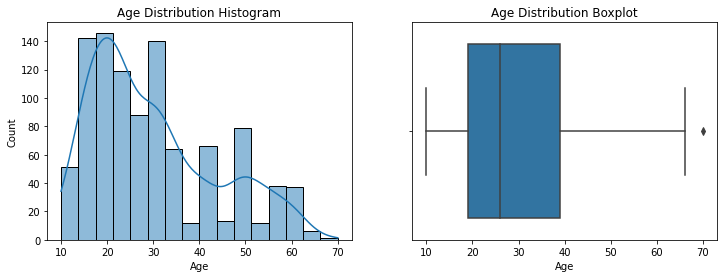

In [10]:
num_plot(data, "Age")

### 4.2.2 SystolicBP

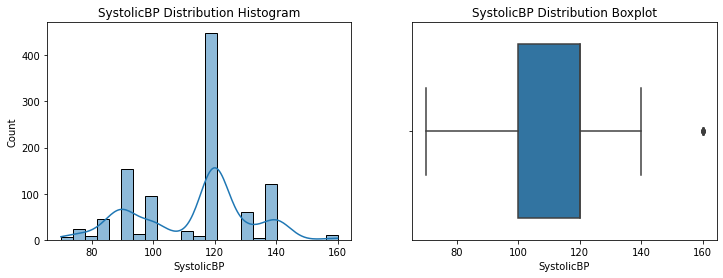

In [11]:
num_plot(data, "SystolicBP")

### 4.2.3 DiastolicBP

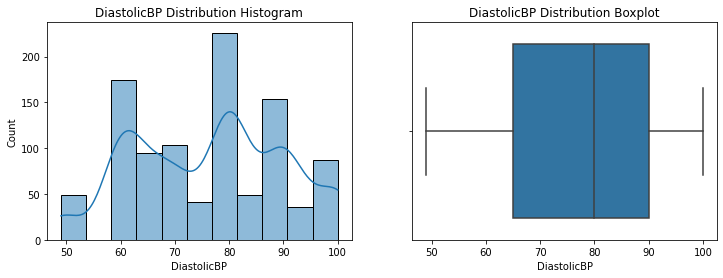

In [12]:
num_plot(data, "DiastolicBP")

### 4.2.4 BS

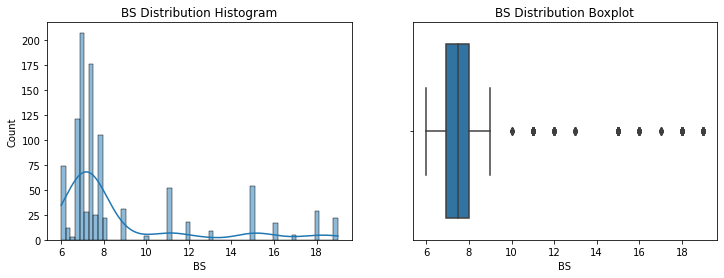

In [13]:
num_plot(data, "BS")

### 4.2.5 BodyTemp

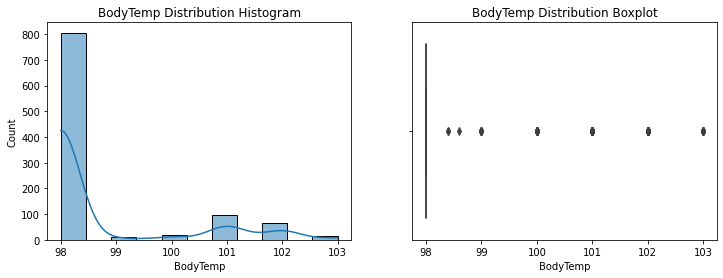

In [14]:
num_plot(data, "BodyTemp")

### 4.2.6 HeartRate

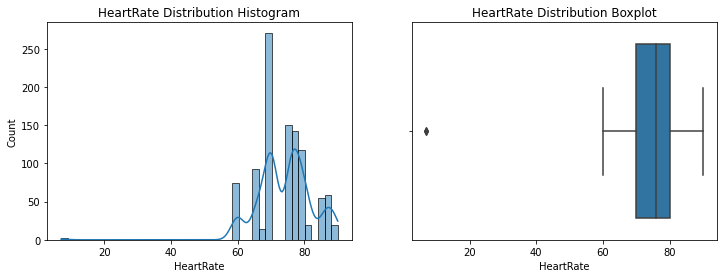

In [15]:
num_plot(data, "HeartRate")

**Observation:**
It appears that nearly all variables exhibit outliers, leading to skewed distributions. Currently, we plan to overlook these outliers as they seem to be inherent to the dataset, except for the variable **HeartRate**. This particular variable has an outlier with a value significantly distant from the rest of the values.

# 5. Bivariate Analysis

Bivariate analysis allows for the assessment of how two variables are interconnected, revealing any potential relationships and the degree of such relationships. This type of analysis focuses on one variable influencing another. Correlation coefficients are useful tools in quantifying the strength of these relationships. Furthermore, scatter plots serve as visual aids to showcase the potential patterns formed by these two variables.

## 5.1 Numerical Variables

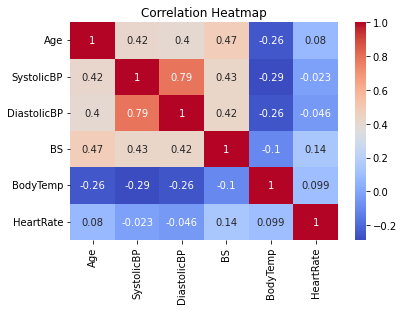

In [16]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Since we only have 6 numerical variables, we'll use pairplot here.

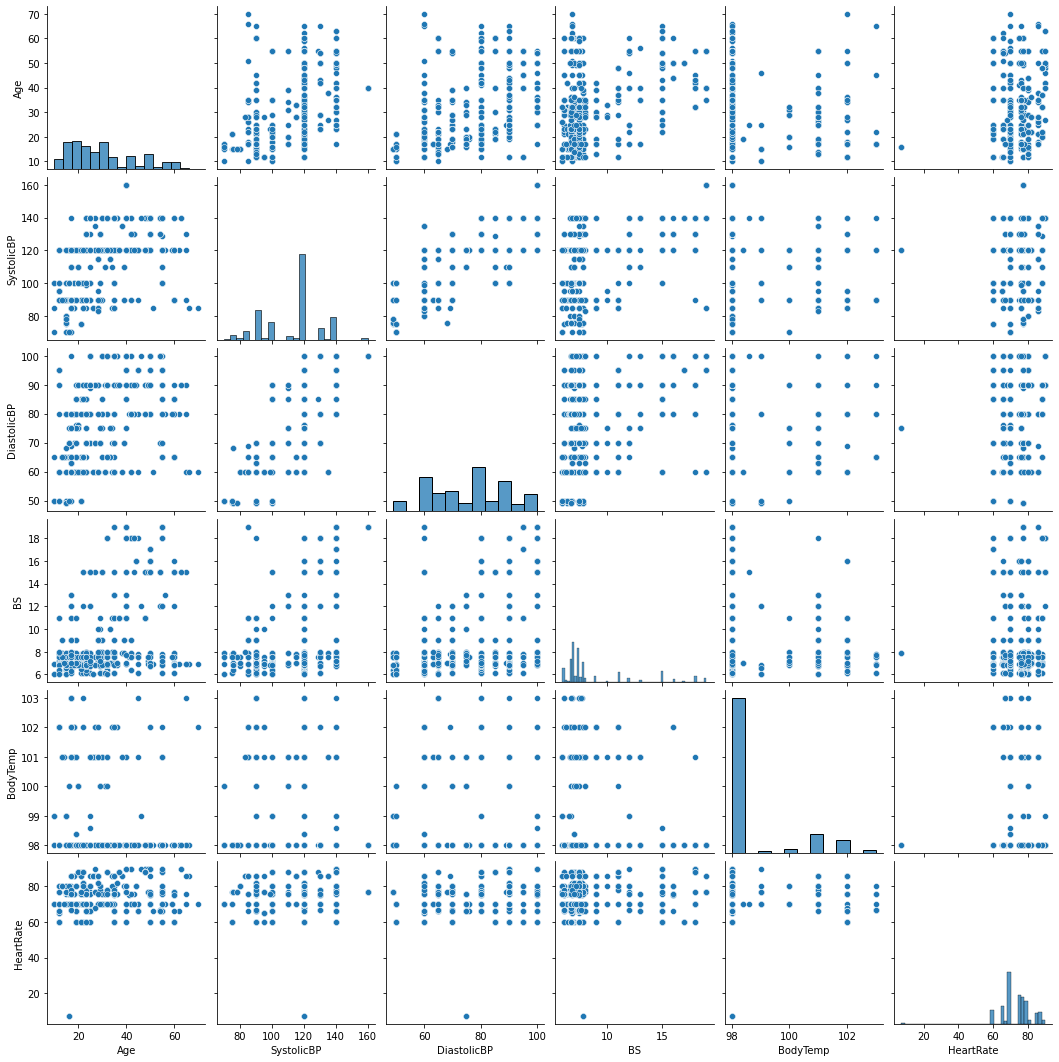

In [17]:
sns.pairplot(data)
plt.show()

The observation reveals a strong positive correlation (correlation coefficient = 0.79) between SystolicBP and DiastolicBP, indicating they carry similar information and suffer from multicollinearity. This can reduce the statistical reliability of these variables as independent predictors in a model. To address this, further analysis is needed to determine if removing one of these variables is necessary and which one should be retained for model training.

## 5.2 Predictor and Target

We will use histogram with hue mapping to visualize the predictor variables data distribution based on the target variable. Also, since our predictor variable only has few unique values, we can also use pandas crosstab to see the detailed values.

### 5.2.1 Age → RiskLevel

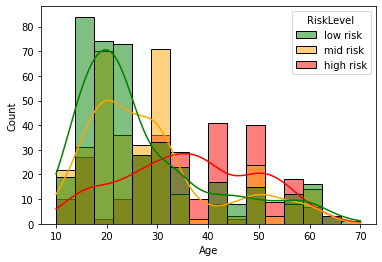

In [18]:
sns.histplot(data=data, x="Age", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [19]:
pd.crosstab(data.RiskLevel, data.Age).style.background_gradient(cmap='summer_r')

Age,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,54,55,56,59,60,62,63,65,66,70
RiskLevel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
high risk,0,7,3,3,0,0,24,0,2,0,0,5,5,0,21,0,2,5,8,10,0,18,2,3,22,2,6,2,2,34,0,4,3,0,1,1,16,2,22,0,9,17,1,0,7,0,2,1,0,0
low risk,2,15,2,0,56,10,18,8,28,11,27,28,42,3,16,0,5,7,2,6,7,18,0,2,21,0,0,0,0,1,1,15,0,0,8,0,4,5,5,1,0,12,0,2,13,1,0,2,1,1
mid risk,2,13,7,0,4,6,21,11,37,11,11,12,24,0,11,3,2,16,30,14,15,12,3,0,7,2,0,0,2,2,0,4,2,3,0,0,6,2,16,0,3,8,0,0,14,0,0,0,0,0


**Observations:**
1. Among pregnant women under 24 years old, the majority tend to have low health risks.
2. There is a noticeable escalation in health risks after the age of 25 years.
3. Pregnant women aged over 59 years exhibit a decrease in health risks.

### 5.2.2 SystolicBP → RiskLevel

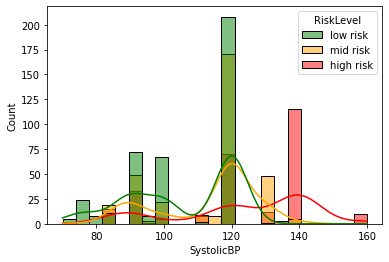

In [20]:
sns.histplot(data=data, x="SystolicBP", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [21]:
pd.crosstab(data.RiskLevel, data.SystolicBP).style.background_gradient(cmap='summer_r')

SystolicBP,70,75,76,78,80,83,85,90,95,99,100,110,115,120,129,130,135,140,160
RiskLevel,,,,,,,,,,,,,,,,,,,
high risk,0,0,0,0,0,2,13,33,1,0,5,8,0,70,0,12,3,115,10
low risk,5,8,16,3,5,0,11,72,8,2,65,2,0,208,1,0,0,0,0
mid risk,2,0,0,0,0,0,19,49,3,0,22,9,8,171,0,48,0,5,0


**Observations:**
1. Pregnant women with a systolic blood pressure value of 100 mmHg or higher typically exhibit low health risks.
2. There is a positive correlation between higher blood pressure levels in pregnant women and increased health risks.

### 5.2.3 DiastolicBP → RiskLevel

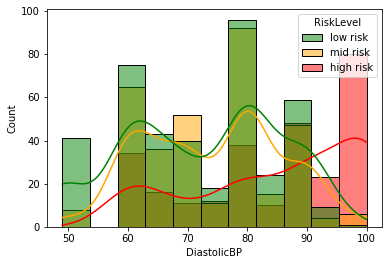

In [22]:
sns.histplot(data=data, x="DiastolicBP", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [23]:
pd.crosstab(data.RiskLevel, data.DiastolicBP).style.background_gradient(cmap='summer_r')

DiastolicBP,49,50,60,63,65,68,69,70,75,76,80,85,89,90,95,100
RiskLevel,,,,,,,,,,,,,,,,
high risk,0,0,34,2,14,0,1,10,12,0,38,10,0,48,23,80
low risk,25,16,75,2,41,2,0,38,15,3,96,24,1,58,9,1
mid risk,0,8,65,4,32,0,0,52,11,0,92,15,0,47,4,6


**Observation:**
1. This variable has pretty similar pattern as SystolicBP. This is not surprising since they're highly correlated.

### 5.2.4 BS → RiskLevel

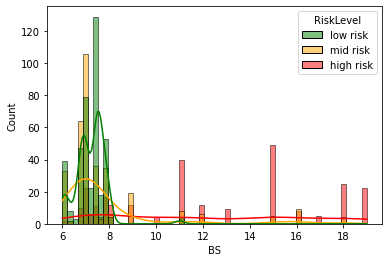

In [24]:
sns.histplot(data=data, x="BS", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [25]:
pd.crosstab(data.RiskLevel, data.BS).style.background_gradient(cmap='summer_r')

BS,6.0,6.1,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.01,7.1,7.2,7.5,7.6,7.7,7.8,7.9,8.0,9.0,10.0,11.0,12.0,13.0,15.0,16.0,17.0,18.0,19.0
RiskLevel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
high risk,0,2,2,0,0,0,0,10,8,9,5,0,6,11,0,4,5,12,12,12,4,40,12,9,49,8,5,25,22
low risk,7,32,0,8,1,2,10,37,47,29,3,8,14,129,1,17,19,34,4,0,0,4,0,0,0,0,0,0,0
mid risk,14,19,0,2,0,0,23,41,58,41,7,0,0,36,0,3,21,14,6,19,0,8,6,0,5,9,0,4,0


**Observation:**
1. Almost every pregnant women with blood glucose level >= 8 has high health risk.
2. But otherwise, they seems to have lower health risk with blood glucose < 8

### 5.2.5 BodyTemp → RiskLevel

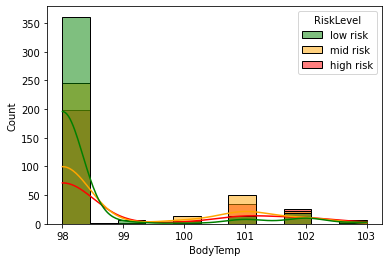

In [26]:
sns.histplot(data=data, x="BodyTemp", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [27]:
pd.crosstab(data.RiskLevel, data.BodyTemp).style.background_gradient(cmap='summer_r')

BodyTemp,98.0,98.4,98.6,99.0,100.0,101.0,102.0,103.0
RiskLevel,,,,,,,,
high risk,199,0,1,2,5,34,25,6
low risk,359,2,0,6,2,14,18,5
mid risk,246,0,0,2,13,50,23,2


**Observation:**
1. Most pregnant women seem to have a body temperature of 98 F, which is normal body temperature
2. Pregnant women with body temperature >= 100 mostly has higher health risk

### 5.2.6 HeartRate → RiskLevel

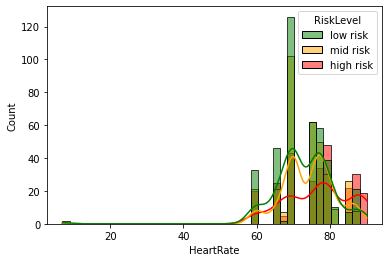

In [28]:
sns.histplot(data=data, x="HeartRate", hue="RiskLevel", kde=True, hue_order=risk_order, palette=p_colors)
plt.show()

In [29]:
pd.crosstab(data.RiskLevel, data.HeartRate).style.background_gradient(cmap='summer_r')

HeartRate,7,60,65,66,67,68,70,75,76,77,78,80,82,86,88,90
RiskLevel,,,,,,,,,,,,,,,,
high risk,0,20,0,25,5,0,43,6,20,25,9,48,0,22,30,19
low risk,2,33,2,44,2,0,126,7,55,56,2,39,10,7,21,0
mid risk,0,21,3,18,5,2,102,6,56,15,35,30,9,26,8,0


**Observation:**
1. As mentioned before, HeartRate variable has outlier that with a value that looks unnatural, which is 7 bpm.
2. Health risks seem to be getting higher along with the number of heart rate.

# 6. Multivariate Analysis

Multivariate analysis entails examining multiple variables (typically more than two) to detect potential associations and understand the relationships among them. Specifically, we aim to link more than one predictor variable with the response variable.

In this scenario, we will focus on evaluating the influence of two distinct predictor variables on the RiskLevel variable. We will utilize scatter plots since all our predictor variables have numerical values, and then group them based on RiskLevel values using different colors.

## 6.1 Age and SystolicBP → RiskLevel

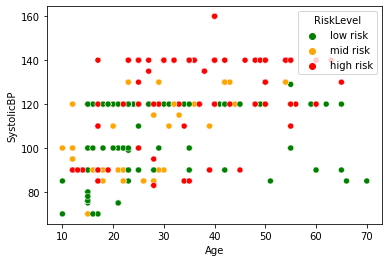

In [30]:
sns.scatterplot(data=data, x="Age", y="SystolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with high SystolicBP seems to have a high health risk, regardless of their age.
2. Having low SystolicBP at a young age (under 50 years) doesn't guarantee our health risk is low, but it seems to have it in old age makes our health risks lower.

## 6.2 Age and DiastolicBP → RiskLevel

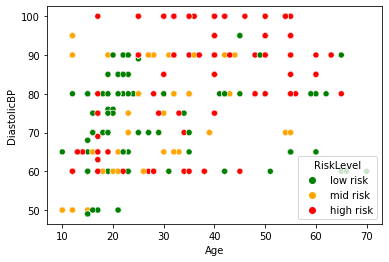

In [31]:
sns.scatterplot(data=data, x="Age", y="DiastolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. We can see the same pattern as before, since SystolicBP and DiastolicBP are highly correlated

## 6.3 Age and BS → RiskLevel

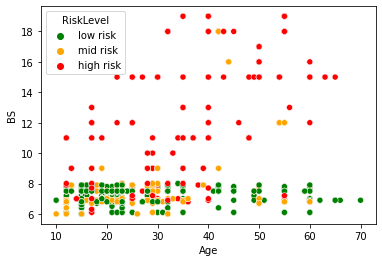

In [32]:
sns.scatterplot(data=data, x="Age", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with high blood glucose level seems to have a high health risk, regardless of their age.

## 6.4 Age and BodyTemp → RiskLevel

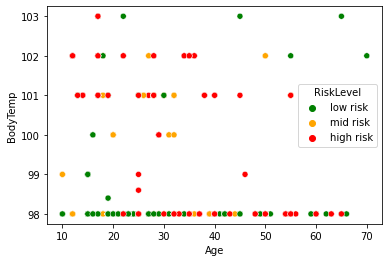

In [33]:
sns.scatterplot(data=data, x="Age", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Younger women with normal body temperature mostly have low health risk, but they'll have higher risk if they have high body temperature.
2. High body temperature for older women doesn't doesn't appear to significantly affect their health risks

## 6.5 Age and HeartRate → RiskLevel

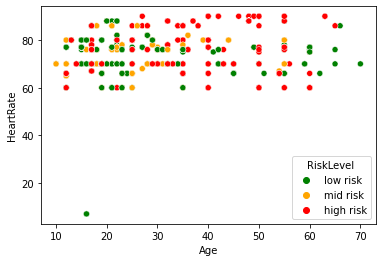

In [34]:
sns.scatterplot(data=data, x="Age", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. It seems that heart rate has less effect on pregnant women's health risk compared to age

## 6.6 SystolicBP and DiastolicBP → RiskLevel

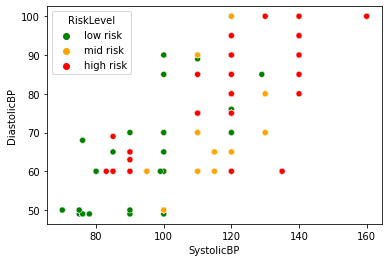

In [35]:
sns.scatterplot(data=data, x="SystolicBP", y="DiastolicBP", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Apparently, pregnant women with lower SystolicBP and DiastolicBP seems to have a lower health risk.
2. But otherwise, the higher SystolicBP and DiastolicBP they have, the higher their health risk.

## 6.7 SystolicBP and BS → RiskLevel

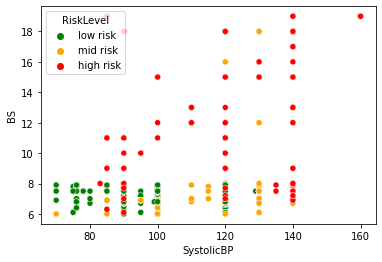

In [36]:
sns.scatterplot(data=data, x="SystolicBP", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. We can see almost similar pattern as before.
2. However, a higher BS value seems to affect the health risks of pregnant women more.

## 6.8 SystolicBP and BodyTemp → RiskLevel

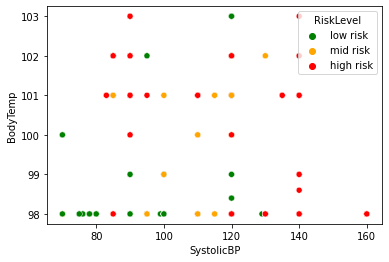

In [37]:
sns.scatterplot(data=data, x="SystolicBP", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with normal body temperature and low SystolicBP mostly has low health risk.
2. But the one who has high SystolicBP seems to have higher health risk, regardless of their body temperature.

## 6.9 SystolicBP and HeartRate → RiskLevel

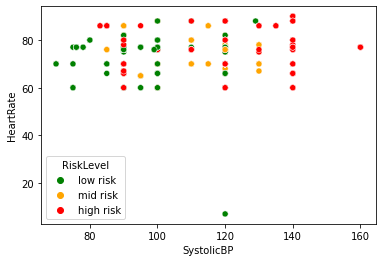

In [38]:
sns.scatterplot(data=data, x="SystolicBP", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. HeartRate value seems has less effect on pregnant women's health risk compared to SystolicBP.
2. Looks like HeartRate variabel isn't really useful.

## 6.10 DiastolicBP and BS → RiskLevel

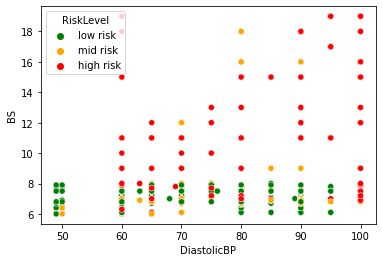

In [39]:
sns.scatterplot(data=data, x="DiastolicBP", y="BS", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with high blood glucose level has higher health risk, regardless of their DiastolicBP.

## 6.11 DiastolicBP and BodyTemp → RiskLevel

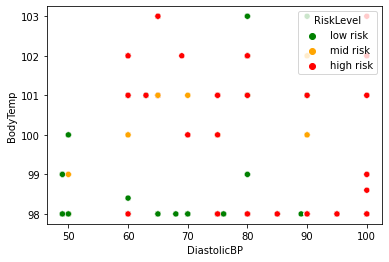

In [40]:
sns.scatterplot(data=data, x="DiastolicBP", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with low DiastolicBP and low body temperature mostly has low health risk, but their health risk will get higher if they have higher body temperature.

## 6.12 DiastolicBP and HeartRate → RiskLevel

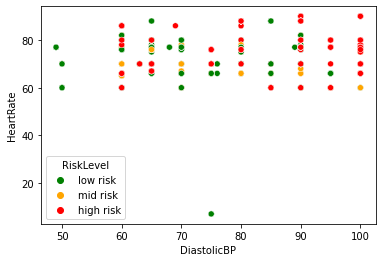

In [41]:
sns.scatterplot(data=data, x="DiastolicBP", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Again, HeartRate value seems has less effect on pregnant women's health risk compared to DiastolicBP.
2. Looks like HeartRate variabel isn't really useful.

## 6.13 BS and BodyTemp → RiskLevel

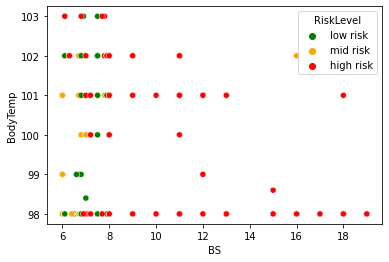

In [42]:
sns.scatterplot(data=data, x="BS", y="BodyTemp", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with high blood glucose level seems to have a high health risk, regardless of their body temperature.

## 6.14 BS and HeartRate → RiskLevel

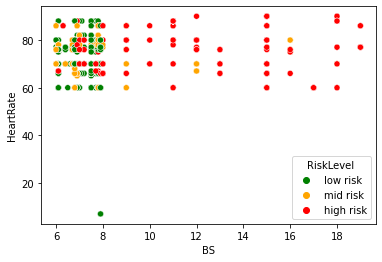

In [43]:
sns.scatterplot(data=data, x="BS", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Apparently, Pregnant women with higher blood glucose level seems to have a higher health risk, regardless of their heart rate.

## 6.15 BodyTemp and HeartRate → RiskLevel

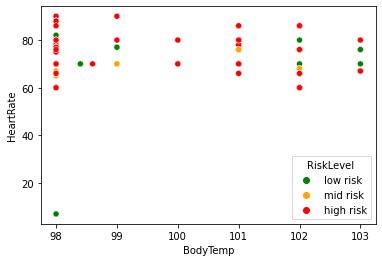

In [44]:
sns.scatterplot(data=data, x="BodyTemp", y="HeartRate", hue="RiskLevel", hue_order=risk_order, palette=p_colors)
plt.show()

**Observation:**
1. Pregnant women with higher body temperature seems to have a higher health risk, regardless of their heart rate (please note that according to previous analysis, pregnant women in this obervation mostly has 98 F body temperature).
2. HeartRate variable really isn't helpful in this case.

# 7. Feature Engineering and Data Cleaning

## 7.1 Outlier Handling

As we know from the previous analysis, several variables in this dataset have outliers, but most of those values still make sense in real life. The only variable that has an outlier with an unreasonable value is HeartRate. In this variable, two observations have a heart rate value of 7 bpm (beats per minute). The average resting heart rate for adults ranges from 60 to 100 beats per minute, and the lowest recorded resting heart rate in human history was 25 bpm. Therefore, we will drop these 2 records with a heart rate value of 7 because that value doesn't make sense and is most likely an input error.

We won't store processed data in the original variable; instead, we will store it in the new variable to compare it with the original data.

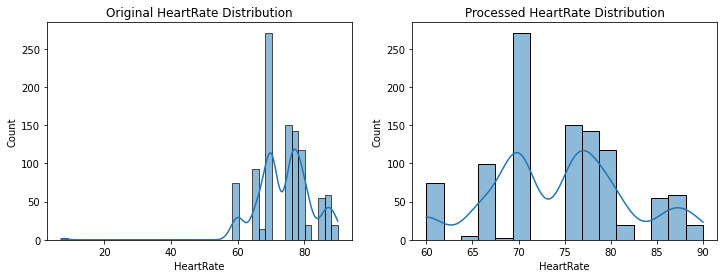

In [45]:
data_proc = data.drop(data.index[data.HeartRate == 7])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=data, x="HeartRate", kde=True, ax=ax[0])
sns.histplot(data=data_proc, x="HeartRate", kde=True, ax=ax[1])
ax[0].set_title("Original HeartRate Distribution")
ax[1].set_title("Processed HeartRate Distribution")
plt.show()

## 7.2 Removing Irrelevant Features

After conducting several analyzes of the predictor variables, we conclude that the HeartRate variable is less helpful in determining the health risks of pregnant women. So, it's safe to remove that variable.

In [46]:
data_proc = data_proc.drop(["HeartRate"], axis=1)

You might wonder why we choose to drop records with outliers in the HeartRate variable, especially if we plan to remove that variable eventually. The reason is that these outliers likely represent input errors, indicating potentially inaccurate or illegitimate data. Including such records could mislead the training process and lead to reduced accuracy in the model. Therefore, it's essential to remove them to ensure the reliability of the dataset for training purposes.

# 8. Model Building

## 8.1 Splitting Dataset

We will split our dataset into 80% train data and 20% test data.

In [47]:
# Original Dataset
X = data.drop("RiskLevel", axis=1)
y = data.RiskLevel
x_train, x_test, y_train, y_test = split(X, y, test_size=0.2, random_state=1)

# Processed Dataset
X_proc = data_proc.drop("RiskLevel", axis=1)
y_proc = data_proc.RiskLevel
x_train_proc, x_test_proc, y_train_proc, y_test_proc = split(X_proc, y_proc, test_size=0.2, random_state=1)

print(f"Original data has {x_train.shape[0]} train data and {x_test.shape[0]} test data\n")
print(f"Processes data has {x_train_proc.shape[0]} train data and {x_test_proc.shape[0]} test data")

Original data has 811 train data and 203 test data

Processes data has 809 train data and 203 test data


## 8.2 Building Classification Model

Random Forest is a powerful algorithm for building models because it combines multiple decision trees, each trained on a different subset of the data. It considers each tree's prediction independently and selects the most popular prediction as the final outcome. This method allows Random Forest to handle classifiers with weak correlations and create a strong overall classifier. We opted for Random Forest due to its high accuracy, fast training times, and ability to work with datasets containing features of varying scales, eliminating the need for normalization or feature scaling.

In [48]:
# Using original dataset
rf = RandomForestClassifier(random_state=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Original Dataset Accuracy: {accuracy_score(y_test, y_pred)}")

# Using processed dataset
rf2 = RandomForestClassifier(random_state=100)
rf2.fit(x_train_proc, y_train_proc)
y_pred = rf2.predict(x_test_proc)
print(f"Processed Dataset Accuracy: {accuracy_score(y_test_proc, y_pred)}")

Original Dataset Accuracy: 0.8669950738916257
Processed Dataset Accuracy: 0.8916256157635468


We got 2.46% more test data accuracy with our processed dataset. It shows that our model has better generalization with our processed dataset to our test data. Not only that, Random Forest also has several hyperparameters that we can adjust to get a model with even better generalization.

## 8.3 Hyperparameter Tuning

We will try to adjust 2 of Random Forest parameters, which is n_estimators and criterion. n_estimator is the number of trees in the forest, while criterion is the function to measure the quality of a split. To do that, we will use GridSearchCrossValidation with the number of folds as much as 10. 

In [49]:
params = {
    "n_estimators": [10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(rf, params, cv=10)
grid.fit(x_train_proc, y_train_proc)
print("Best hyperparameter:", grid.best_params_)

Best hyperparameter: {'criterion': 'gini', 'n_estimators': 50}


In [50]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")[["params", "mean_test_score", "rank_test_score"]]

,params,mean_test_score,rank_test_score
2,"{'criterion': 'gini', 'n_estimators': 50}",0.831867,1
3,"{'criterion': 'gini', 'n_estimators': 100}",0.830648,2
7,"{'criterion': 'entropy', 'n_estimators': 100}",0.828179,3
6,"{'criterion': 'entropy', 'n_estimators': 50}",0.828164,4
1,"{'criterion': 'gini', 'n_estimators': 20}",0.823241,5
5,"{'criterion': 'entropy', 'n_estimators': 20}",0.822006,6
4,"{'criterion': 'entropy', 'n_estimators': 10}",0.818210,7
0,"{'criterion': 'gini', 'n_estimators': 10}",0.808302,8


In [51]:
y_pred = grid.predict(x_test_proc)
print(f"Processed Dataset Accuracy: {accuracy_score(y_test_proc, y_pred)}")

Processed Dataset Accuracy: 0.9014778325123153


In [52]:
from sklearn.metrics import classification_report

print("Random Forest Classification Report\n\n", classification_report(y_test_proc, y_pred))

Random Forest Classification Report

               precision    recall  f1-score   support

   high risk       0.95      0.97      0.96        64
    low risk       0.92      0.86      0.89        79
    mid risk       0.83      0.88      0.85        60

    accuracy                           0.90       203
   macro avg       0.90      0.90      0.90       203
weighted avg       0.90      0.90      0.90       203



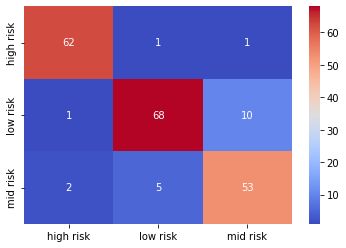

In [53]:
labels = np.unique(y_pred)
sns.heatmap(confusion_matrix(y_test_proc, y_pred), annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.show()

That's it. After doing hyperparameter tuning, we got the best value for criterion is 'gini' and n_estimators is 50. With that parameter value, the accuracy of the resulting model increased by almost 1% to the test data. Although it's not much, but still there is an improvement from the resulting model.

# Conclusion

Based on our dataset analysis, we can infer that blood glucose level (BS) is the most critical factor in assessing the health status of pregnant women. Those with high BS levels are more likely to face elevated health risks, with over 75% of those with a BS of 8 or higher falling into this category. BS also shows a strong positive correlation with Age, systolicBP, and diastolicBP, indicating that pregnant women with higher levels in these areas should be more cautious. Age is also noteworthy, as health risks seem to escalate notably from the age of 25. SystolicBP and DiastolicBP exhibit a strong relationship, evident from their correlation coefficient of 0.79.

In contrast, BodyTemp doesn't offer significant insights due to the overwhelming presence of values around 98F; however, temperatures above 98.4F suggest higher health risks. Heart rate appears to be the least influential variable in assessing pregnant women's health levels.

Moving forward, we propose using the Random Forest algorithm for classification modeling on this dataset. Initially, our model achieved an accuracy of 86.7%. However, after conducting feature engineering, data cleaning (including outlier removal and irrelevant variable deletion), and hyperparameter tuning, our accuracy improved to 90.15%, indicating better model generalization with the processed dataset.